# Assignment 8: BHC Analysis using Python
#### Group: Mitchell Kramer, Nicholas Meyer,  Nikita Tatarinov, Glenn Matlin, Michael Galarnyk

In [ ]:
!brew install graphviz

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 
from tqdm import tqdm

from scipy.stats import skew, kurtosis
from scipy.stats import ttest_1samp
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import acovf
from statsmodels.stats.sandwich_covariance import cov_hac

import yfinance as yf

## Assignment Description

The goal of the assignment is to understand banks financial statements and the risks they are
exposed to. There are a number of issues (listed below) that I want the students to address
in the assignment report. Each group is expected to pick a bank or bank holding company.

1. Draw a random number generated using one of the team member gtid as a seed over theinterval (1, 25). List the seed and your random number at the top of the report.
2. You can select the random number using Python
3. Select the corresponding bank (rank based on size that is the same as the random number) at https://www.ffiec.gov/npw/Institution/TopHoldings
4. If the BHC is not publicly listed in the U.S., redraw the random number
5. I will cold call students in class to describe their findings about their assigned bank in the class

In [7]:
# Dictionary provided by the user
group_id = {
    "Glenn Matlin": 903738044,
    "Nikita Tatarinov": 903914813,
    "Michael Galarnyk": 903918895,
    "Mitchell Kramer": 903176941,
    "Nicholas Meyer": 903444783
}

# Initialize a list to hold the random numbers
random_numbers = []

# Iterate over the GTIDs in the group_id dictionary
# For each GTID, we set it as the seed and generate a random number
for name, gtid in group_id.items():
    np.random.seed(gtid)  # Set the seed
    random_num = np.random.randint(1, 26)  # Generate the random number
    random_numbers.append(random_num)  # Append to the list

# Create a DataFrame from the group_id dictionary and the list of random numbers
df = pd.DataFrame(list(group_id.items()), columns=['Student', 'GTID'])
df['Random_Number'] = random_numbers  # Add the random numbers to the DataFrame


In [8]:
holding_df = pd.read_csv("data/LargeHoldingCompanies.csv")

# Get Bank Names
df = pd.merge(df,
         holding_df,
         left_on='Random_Number', right_on='Rank', how='left')

In [9]:
df

,Student,GTID,Random_Number,Rank,Name,RSSDID,Location,TotalAsset
0,Glenn Matlin,903738044,9,9,TRUIST FINANCIAL CORPORATION ...,1074156,"CHARLOTTE, NC",5.545490e+08
1,Nikita Tatarinov,903914813,9,9,TRUIST FINANCIAL CORPORATION ...,1074156,"CHARLOTTE, NC",5.545490e+08
2,Michael Galarnyk,903918895,17,17,HSBC NORTH AMERICA HOLDINGS INC. ...,3232316,"NEW YORK, NY",2.236565e+08
3,Mitchell Kramer,903176941,1,1,JPMORGAN CHASE & CO. ...,1039502,"NEW YORK, NY",3.868240e+09
4,Nicholas Meyer,903444783,16,16,AMERICAN EXPRESS COMPANY ...,1275216,"NEW YORK, NY",2.449040e+08


# Links


[Reporting on JP Morgan Chase from the National Information Center of the Federal Financial Institutions Examination Council](https://www.ffiec.gov/npw/Institution/Profile/1039502?dt=20190519)

[All 10-K Filings to the SEC from JP Morgan Chase](https://jpmorganchaseco.gcs-web.com/?field_nir_sec_form_group_target_id%5B%5D=471&field_nir_sec_date_filed_value=)

[JP Morgan at Yahoo Finance](https://finance.yahoo.com/quote/JPM/)

## Section 1: Current Information about the bank

This section should be brief. One paragraph.
1. What are the various business units of the bank (for example, is the bank a pure commercial bank or does it engage in investment banking and other financial businesses?). You can get this information from the firm’s 10-K.

***JPMorgan Chase & Co.***, a global financial powerhouse, operates through **four** distinct business units, each catering to a specific facet of financial services.

1. The **Consumer & Community Banking (CCB)** segment provides a range of services to individual consumers and small businesses, emphasizing personal banking, lending, and investment needs.

2. The **Corporate & Investment Bank (CIB)** delivers a comprehensive suite of investment banking, market-making, and treasury services, focusing on high-end corporate and institutional clients.

3. In the **Commercial Banking (CB)** segment, the focus is on serving larger businesses, offering lending, investment, and financial solutions tailored to their complex needs.

4. The **Asset & Wealth Management (AWM)** arm provides investment and wealth management services, catering to a diverse clientele including high-net-worth individuals and institutional investors.

| Subsidiary Name                                       | Organized Under The Laws Of |
|-------------------------------------------------------|-----------------------------|
| JPMorgan Chase Bank, National Association             | United States               |
| Paymentech, LLC                                       | United States               |
| J.P. Morgan International Finance Limited             | United States               |
| JPMorgan Securities Japan Co., Ltd.                   | Japan                       |
| J.P. Morgan Capital Holdings Limited                  | United Kingdom              |
| J.P. Morgan Securities PLC                            | United Kingdom              |
| J.P. Morgan SE                                        | Germany                     |
| JPMorgan Chase Holdings LLC                           | United States               |
| J.P. Morgan Services India Private Limited            | India                       |
| JPMorgan Asset Management Holdings Inc.               | United States               |
| JPMorgan Distribution Services, Inc.                  | United States               |
| JPMorgan Asset Management International Limited       | United Kingdom              |
| JPMorgan Asset Management (UK) Limited                | United Kingdom              |
| JPMorgan Asset Management Holdings (Luxembourg) S.à r.l. | Luxembourg             |
| JPMorgan Asset Management (Europe) S.à r.l.           | Luxembourg                  |
| J.P. Morgan Investment Management Inc.                | United States               |
| J.P. Morgan Broker-Dealer Holdings Inc.               | United States               |
| J.P. Morgan Securities LLC                            | United States               |
*Table Description: Primary Subsidiaries of JPMC, as disclosed in 10-K*

## Section 2: Understand the Ownership Structure

Analyze (see yahoo finance or Bloomberg or the company’s investor website for the ownership structure). The data needs to be extracted using Python from the relevant URL. This section should be brief. One paragraph with data tables / graphs in the appendix.
1. Institutional Ownership
2. Non-Institutional Ownership
3. Insider Ownership

Are the insiders buying or selling the stock recently?

In [398]:
import time
from geopy.geocoders import Nominatim, get_geocoder_for_service
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
import plotly.express as px
import networkx as nx
import plotly.graph_objects as go
from networkx.drawing.nx_agraph import graphviz_layout
import textwrap

### NIC Hierarchy Data

In [379]:
hierarchy = pd.read_csv('./data/hierarchy.csv')

In [393]:
def geocode_address(city, state, country="USA"):
    """Geocode address to get latitude and longitude."""
    try:
        geolocator = Nominatim(user_agent="geoapiExercises")
        location = geolocator.geocode(f"{city}, {state}, {country}")
        if location:
            return location.latitude, location.longitude
        return None, None
    except (GeocoderTimedOut, GeocoderServiceError):
        return None, None

In [394]:
print(hierarchy.iloc[0]['City'], hierarchy.iloc[0]['StateOrCountry'])

NEW YORK NY


In [395]:
geocode_address(city=hierarchy.iloc[0]['City'], state=hierarchy.iloc[0]['StateOrCountry'])

(None, None)

In [397]:
geocode_address(city='New York', state='NewY')

(None, None)

In [ ]:
# Add latitude and longitude columns to your DataFrame with rate limiting
for index, row in tqdm(hierarchy.iterrows()):
    lat, lon = geocode_address(row['City'], row['StateOrCountry'])
    hierarchy.at[index, 'latitude'] = lat
    hierarchy.at[index, 'longitude'] = lon
    time.sleep(1)  # Sleep for 1 second between requests

In [ ]:
fig = px.scatter_geo(df,
                     lat='latitude',
                     lon='longitude',
                     hover_name='InstitutionName',
                     hover_data=['City', 'StateOrCountry'],
                     title='Institutions Map')
fig.update_layout(showlegend=False)
fig.show()

In [53]:
def build_interactive_corporate_structure_graph(hierarchy):
    # Create a directed graph
    G = nx.DiGraph()

    # Iterate over rows in the DataFrame
    for _, row in hierarchy.iterrows():
        # Add a node for the institution
        G.add_node(row['RssdId'], label=row['InstitutionName'])

        # Check if the institution has a parent and add an edge
        if not pd.isna(row['ParentId']):
            G.add_edge(row['ParentId'], row['RssdId'])

    # Calculate positions of nodes in a hierarchical layout using pygraphviz
    pos = graphviz_layout(G, prog='dot', args='-Gnodesep=1 -Granksep=2')

    # Assign positions to node attributes
    for node in G.nodes:
        G.nodes[node]['pos'] = pos[node]

    # Create Edges
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = G.nodes[edge[0]]['pos']
        x1, y1 = G.nodes[edge[1]]['pos']
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    # Create Nodes
    node_x = []
    node_y = []
    text = []
    for node in G.nodes():
        x, y = G.nodes[node]['pos']
        node_x.append(x)
        node_y.append(y)
        wrapped_label = textwrap.fill(G.nodes[node]['label'], width=15)  # Adjust width as needed
        text.append(wrapped_label)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        text=text,
        marker=dict(
            size=10,  # Adjust node size as needed
            line_width=2),
        textposition="middle center",
        textfont=dict(
            size=10  # Adjust text size as needed
        ))

    # Create Figure with increased size
    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20,l=5,r=5,t=40),
                        width=800,  # Adjust figure width as needed
                        height=800  # Adjust figure height as needed
                    ))

    # Display the Figure
    fig.show()

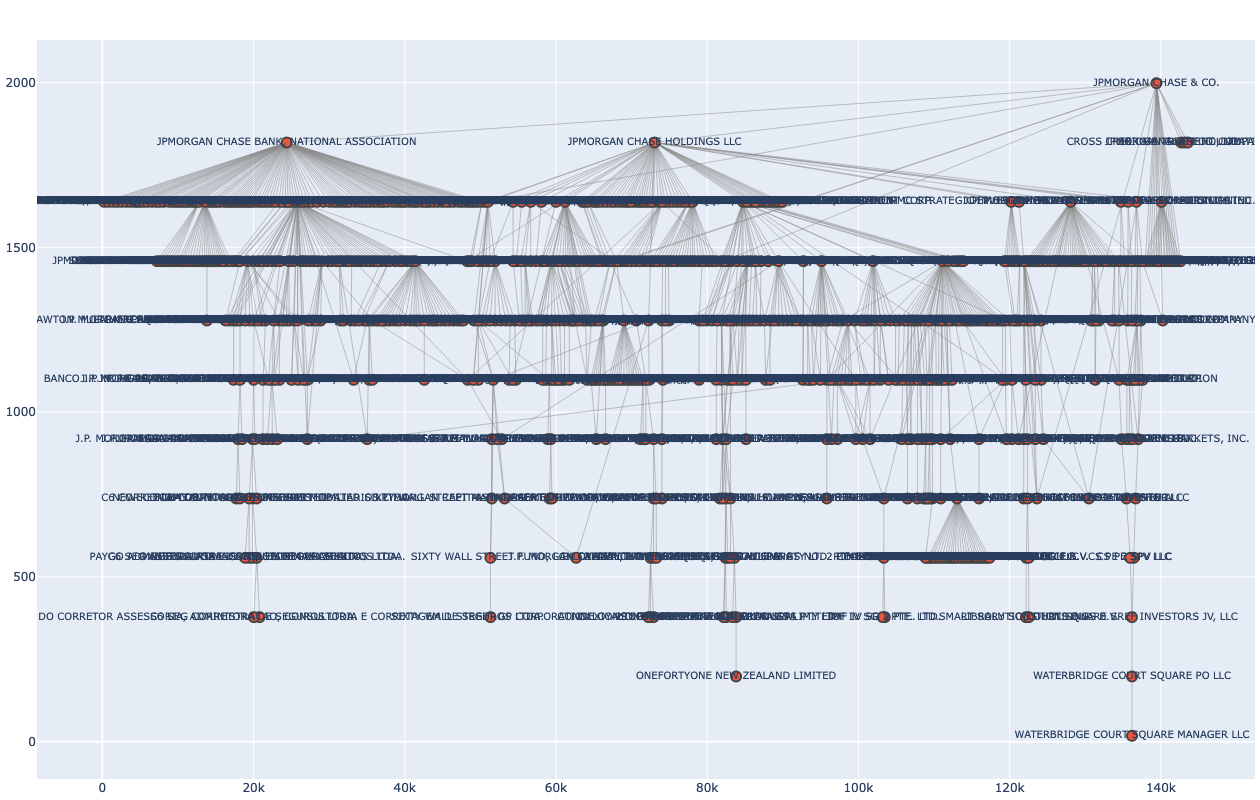

In [54]:
build_interactive_corporate_structure_graph(hierarchy)

## Yahoo Finance

In [196]:
# Ticker symbol for JPMorgan Chase & Co.
ticker_symbol = "jpm"

# Fetch all available data
jpm = yf.Ticker(ticker_symbol)

*Currently Unused Yahoo API Data*:
```python
financials = jpm.financials

balance_sheet = jpm.balance_sheet

quarterly_balance_sheet = jpm.quarterly_balance_sheet

cashflow = jpm.cashflow

quarterly_cashflow = jpm.quarterly_cashflow

dividends_splits = jpm.actions  # dividends and splits

options = jpm.options

stock_info = jpm.info
```

In [377]:
jpm_historical = jpm.history(period="max")

In [207]:
quarterly_financials = jpm.quarterly_financials

In [315]:
major_holders = jpm.major_holders
major_holders.columns = ['Percent','Description']

In [316]:
institutional_holders = jpm.institutional_holders
institutional_holders['Type'] = "Institution"

In [317]:
mutual_fund_holders = jpm.mutualfund_holders
mutual_fund_holders['Type']="Non-Institutional"

In [318]:
insider_holders_pct = float(major_holders.query("Description == '% of Shares Held by All Insider'")['Percent'].loc[0].replace('%',''))/100

In [319]:
total_shares = quarterly_financials.loc[:,'2023-06-30']['Basic Average Shares']

In [320]:
share_price = (jpm_historical.loc[as_of_date]['High']+jpm_historical.loc[as_of_date]['Low'])/2

In [321]:
insider_shares = int(insider_holders_pct * total_shares)

In [282]:
insider_value = int(insider_shares * share_price)

In [322]:
insider_trading = pd.DataFrame(pd.Series({'Holder': 'Insiders',
 'Shares': insider_shares,
 'Date Reported': pd.Timestamp('2023-06-30 00:00:00'),
 '% Out': insider_holders_pct,
 'Value': insider_value,
 'Type': 'Insiders'})).T

In [324]:
other_pct = 0# 1-ownership['% Out'].sum()
other_shares = int(other_pct * total_shares)
other_value = int(other_shares * share_price)

In [367]:
ownership = pd.concat([insider_trading, institutional_holders, mutual_fund_holders])

other_owners = pd.DataFrame(pd.Series({'Holder': 'Information Unavailable',
 'Shares': int(total_shares - ownership['Shares'].sum()),
 'Date Reported': pd.Timestamp('2023-06-30 00:00:00'),
 '% Out': 1-ownership['% Out'].sum(),
 'Value': int(int(total_shares - ownership['Shares'].sum()) * share_price),
 'Type': 'Other'})).T

ownership = pd.concat([ownership, other_owners])

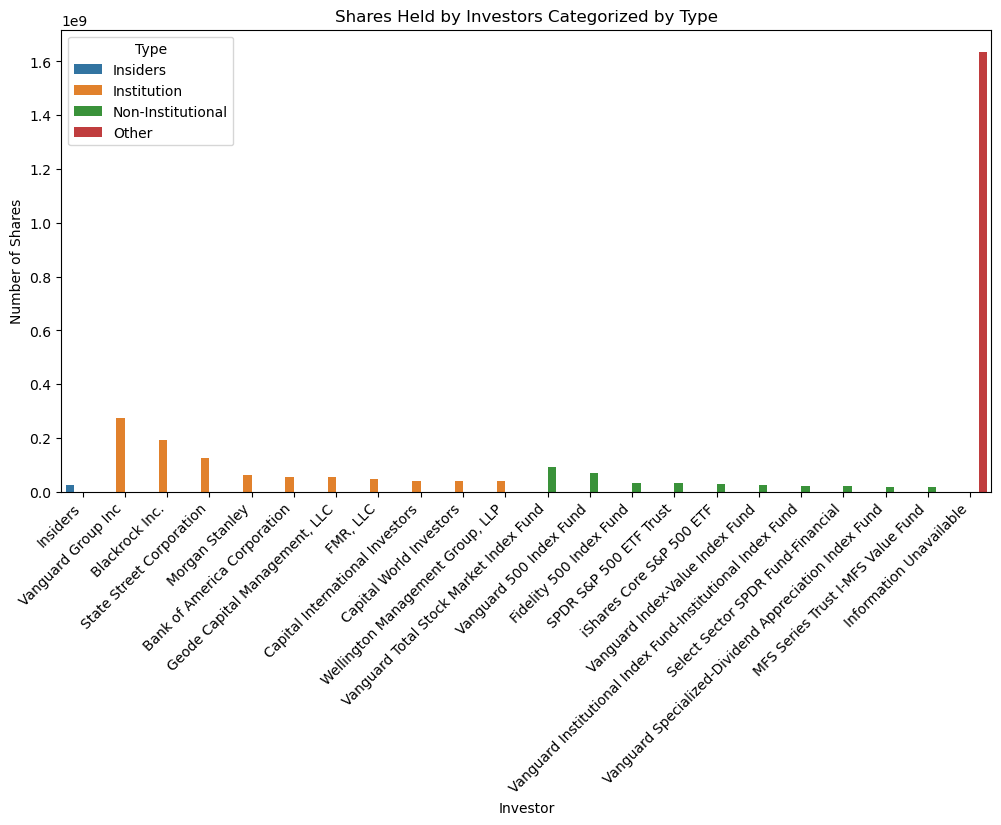

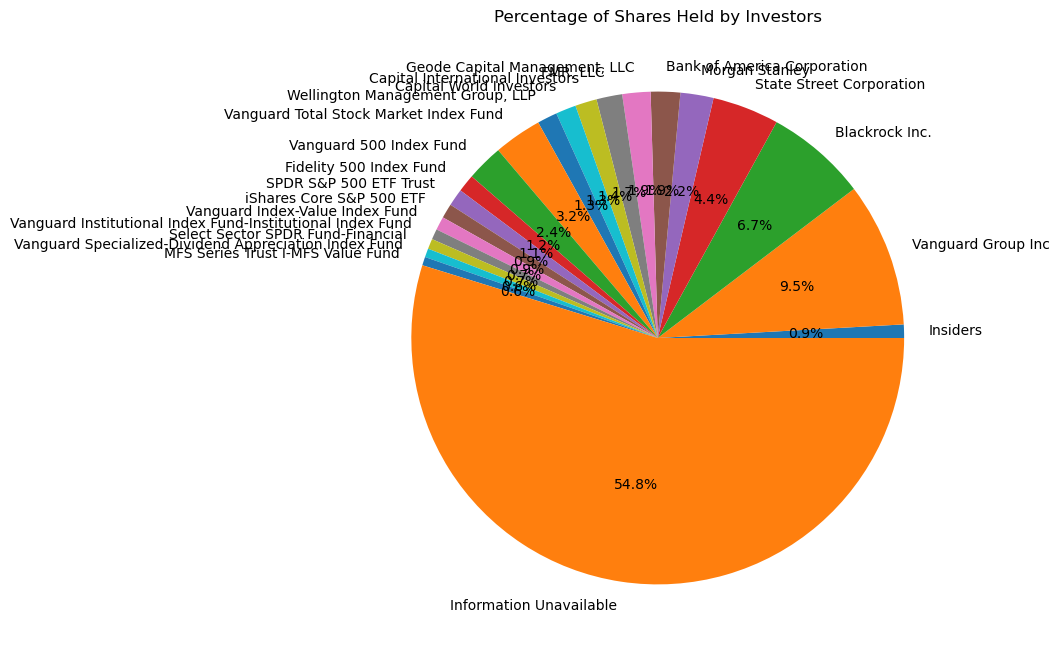

In [376]:
plt.figure(figsize=(12, 6))
sns.barplot(data=ownership, x='Holder', y='Shares', hue='Type')
plt.title('Shares Held by Investors Categorized by Type')
plt.xlabel('Investor')
plt.ylabel('Number of Shares')
plt.xticks(rotation=45, ha='right')
plt.show()

plt.figure(figsize=(8, 8))
plt.pie(ownership['% Out'], labels=ownership['Holder'], autopct='%1.1f%%')
plt.title('Percentage of Shares Held by Investors')
plt.show()

## Section 3: How do the markets view the bank

This section should be a short summary with the corresponding tables in the Appendix
1. Stock Return, Beta, Volatility (compute using Python, translate your previous Rcode into Python)
2. Short-interest in the bank’s stock. days it takes to cover the short-interest (from the exchange or other sources)
3. CDS prices (from bloomberg or some other source). Can show a graph using this data
4. Credit ratings
5. Analyst opinions

## Section 4: Understanding Bank Call Reports

To help with section 5-8 below, first do the following
1. Download the PDF format of the quarterly FRY9-C (as of Dec 2022) for your bank by following your bank link
* https://www.ffiec.gov/npw/Institution/TopHoldings
2. Browse through the statement (you can use control+f to find some of the items) to get the relevant item number for some of the following variables
3. In order to understand the variables, you can see FDIC performance report and description of the ratios.
* https://www.federalreserve.gov/boarddocs/supmanual/bhcpr/UsersGuide13/default.htm
4. Now download the Q4 (as of Dec 12/31) FRY9-C for for the bank for the last five years in CSV format (not manually, make a call inside your python program) by following the bank URL
5. Keep only the variables required for sections 5-8. Stack the quarterly data
6. Plot the variables for the past five years
7. Comment on the patterns that you observe in the data. 1-2 lines per variable. Discuss in the group first.

## Section 5: Performance and Financial Position of the Bank: Very Important

From the FRY9-C (10-K when needed), compute and graph these items over the past 5 years.
1. earnings
2. net interest margins
3. non-interest or fee income
4. revenues, expenses
5. loan mix
6. past due and losses
7. losses and loan reserves
8. liquidity and funding
9. capitalization ratios
10. growth rates
11. asset composition
12. liability composition
13. liquidity and funding (important)
14. maturity gap
15. interest rate sensitivity
16. what is the major source of the bank performance?
17. how did the bank perform compared to the peers? You can get this information from the BHC Performance Report

## Section 6: Risk Profile of the Bank from Management Discussion and Analysis (MD&A) section in 10-K or 10-Q

1. Download the latest 10-K for the bank. If it is not in 2023, you may need to check latest 10-Q.
2. Go to the Management Discussion of Risk Management in the Management Discussion and Analysis (MD&A) section
3. Based on MD&A discussion,
    
    1). Is there a Asset Liability Committe (ALCO)? Describe the framework that the bank
is using for Asset Liability Management (ALM) within the bank
    
    2). Interest Rate Risk
        * How is the bank measuring and managing interest rate risk for ALM?
        * Do they discuss duration and convexity in the context of ALM?
4. How does the bank discuss Liquidity Risk Management?
    * What are some tools and metrics that the bank is using for liquidity risk management?
    * Di they discuss deposit convexity after SVB crisis? (mostly from their 10-Q)
5. Does the bank discuss how Basel III regulations affect their ALM strategies?
6. Describe the banks ALM Models and Assumptions if they disclosed it? How do they validate their ALM models?
7. How is the bank modeling deposits and loan book? What factors are they considering? Is there a scenario analysis?
8. How is the bank adapting their ALM strategy to the rising interest rate environments (may need to see latest 10-Q)
9. Do they discuss any other strategic considerations for ALM strategy and how it fits in the broad risk management framework?

## Section 7: Risk Profile of the Bank from FRY9-C and 10-K / 10-Q

Analyze the risk profile of the bank (under the same headings as the bank risks lecture).
1. Pay special attention to operational risk (fraud etc,)
2. Asset Side Risks
3. Liability side risks
4. Off-balance-sheet risks
5. Regulatory Risk
6. Exposure to real estate markets

## Section 8: Off-balance sheet activities of the Bank from FRY9-C and 10-K / 10-Q

1. Off balance sheet growth over years
2. Components of off-balance sheet
3. Bank’s Derivative Usage. What are the biggest components?
4. Securitization activities
5. Level 1, Level 2 and Level 3 assets of the bank
6. Value at Risk, Expected Shortfall and other Risk Measures noted in the 10-K/10-Q

## Additional Comments

Note:
1. You are expected to learn some new material through this assignment, in addition to the material covered through lectures in the class
2. Present the information in a graphical format to the extent possible. Use Python to generate graphs
3. Part of the task is to decide which financial information is relevant and which is not.
4. Focus on both income statement and balance sheet

## Resources

1. FDIC, NIC and FFIEC websites
2. <b>important </b>https://www.federalreserve.gov/boarddocs/supmanual/bhcpr/UsersGuide13/0313.pdf
3. http://www.federalreserve.gov/boarddocs/supmanual/default.htm#bhcuser
4. https://www.fdic.gov/search/help.html
5. http://www.ffiec.gov/nicpubweb/nicweb/nichome.aspx
6. See the Bank Holding Company Performance Report (BHCPR) at
    * https://www.ffiec.gov/npw/Institution/TopHoldings.
    * Click on your respective bank and then select BHCPR